# PLEASE IGNORE THIS WORKBOOK AND DO NOT CONSIDER IT WHEN GRADING

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import cenpy
import pygris
import altair as alt
import hvplot.pandas

In [32]:
acs2021 = cenpy.remote.APIConnection("ACSDT5Y2021")

variables_acs = ['NAME',
                 'B19013_001E']

df_acs2021 = acs2021.query(
    cols=variables_acs,
    geo_unit="block group:*",
    geo_filter={"state": "42", "county": "101", "tract": "*"},
)

philly_2020_block_groups = pygris.block_groups(
    state="42", county="101", year=2020
).to_crs(6565)

df_acs2021_g = philly_2020_block_groups.merge(
    df_acs2021,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"],
    right_on=["state", "county", "tract", "block group"],
)



In [34]:
df_acs2021_g['Median_Income'] = df_acs2021_g['B19013_001E'].astype(float)
df_acs2021_g = df_acs2021_g[['NAME','state','county','tract','block group','Median_Income','geometry']]

In [35]:
flood_plain_100_year = gpd.read_file('https://opendata.arcgis.com/datasets/1d6d353ab50b4884b586c05ee2a661db_0.geojson').to_crs(6565)
flood_plain_500_year = gpd.read_file('https://opendata.arcgis.com/datasets/1e6f6315225544c88549478d25cc5181_0.geojson').to_crs(6565)
plain_merge = pd.concat([flood_plain_100_year,flood_plain_500_year])

#Maker buffer
buffer = plain_merge.buffer(264)

#Buffer made geoseries - had to convert to a geodataframe to use for further analysis
buffer2 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buffer))

In [36]:
# copy GeoDataFrame
df_acs2021_g['infloodplain'] = False
df_acs2021_g_points = df_acs2021_g.copy()
# change geometry 
df_acs2021_g_points['geometry'] = df_acs2021_g_points['geometry'].centroid

C:\ProgramData\mambaforge\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
#Determine which census tract centroids overlap the flood plain buffer
infloodplain = df_acs2021_g_points.sjoin(buffer2,how='inner').index

df_acs2021_g.iloc[[infloodplain],[7]] = True

In [38]:
def set_inflood_true(df,tract,block):
    filt = (df['tract'] == tract) & (df['block group'] == block)
    df.loc[filt,'infloodplain'] = True
    
def set_inflood_false(df,tract,block):
    filt = (df['tract'] == tract) & (df['block group'] == block)
    df.loc[filt,'infloodplain'] = False
    
set_inflood_true(df_acs2021_g,'989100','2')
set_inflood_true(df_acs2021_g,'980701','2')
set_inflood_true(df_acs2021_g,'980901','4')
set_inflood_true(df_acs2021_g,'036902','4')
set_inflood_true(df_acs2021_g,'037500','1')
set_inflood_true(df_acs2021_g,'014201','2')
set_inflood_true(df_acs2021_g,'980903','1')
set_inflood_true(df_acs2021_g,'003300','2')
set_inflood_true(df_acs2021_g,'003300','2')
set_inflood_true(df_acs2021_g,'035100','2')

set_inflood_false(df_acs2021_g,'035900','2')
set_inflood_false(df_acs2021_g,'036000','3')
set_inflood_false(df_acs2021_g,'980300','1')

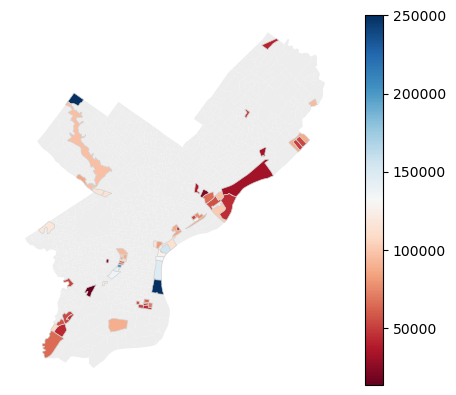

In [55]:
df_acs2021_filt = df_acs2021_g[df_acs2021_g['infloodplain'] == True]
df_acs2021_filt = df_acs2021_filt[df_acs2021_filt['Median_Income'] > 0]

fig, ax = plt.subplots()

df_acs2021_g.plot(ax=ax,edgecolor='none',facecolor='#ededed')
df_acs2021_filt.plot(ax=ax,column='Median_Income',legend=True,cmap='RdBu',edgecolor='lightgrey',linewidth=0.5)

ax.set_axis_off()
ax.set_aspect("equal")